**Дана выборка с изображениями потенциалов (размер 256\*256). Необходимо обучить случайный лес на тренировочной выборке и предсказать энергии потенциалов на тесте**

In [1]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

import matplotlib.pyplot as plt

#####
# если вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Разделим выборку на обучающую и тестовую, попутно посмотрим, как выглядят элементы данной выборки

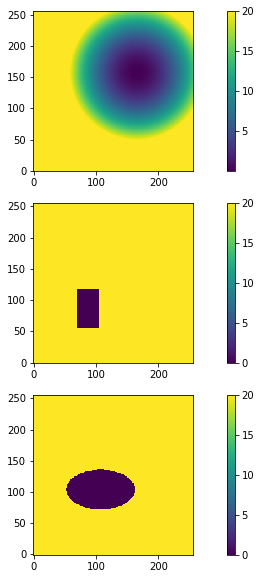

In [3]:
path_to_dataset = "C:/Users/2222/Desktop/public_tests/01_test_potentials_input/train/potentials"

chosen_ones = {'b2399918793e4228a3ea0a0a89adf11b.npz', '513d5523d14c47feb8b544138071c496.npz', 'ca9f96c404b740e3b28f583f9d9afbf8.npz'}

plt.figure(figsize=(12, 10))
from sklearn.preprocessing import StandardScaler
def get_potential_dataset():

    global path_to_dataset

    X, y = [], []

    plot_index = 1
    
    if not path_to_dataset.endswith("/"):
        path_to_dataset += "/"

    for f in os.listdir(path_to_dataset):

        npz = np.load(f'{path_to_dataset}{f}')
        data, target = npz['data'], npz['target']

        X.append(data)
        y.append(target)

        if f in chosen_ones:
            plt.subplot(len(chosen_ones), 1, plot_index)
            plt.imshow(data, origin="lower", interpolation='none')
            plt.colorbar()
            plot_index += 1
    plt.show()
    return train_test_split(np.array(X), np.array(y), random_state=42)

X_train, X_test, y_train, y_test = get_potential_dataset()

*Пояснение к картинкам* - желтый цвет означает отсутствие потенциала в данной точке. Также есть разные виды потенциалов: плавно спускающиеся к минимуму(первая картинка) и разные по форме, резко меняющиеся на 0 (оставшиеся картинки)  

Проблема - случайный лес работает с векторами признаков, а здесь же матрица. Значит, надо эти признаки преобразовывать

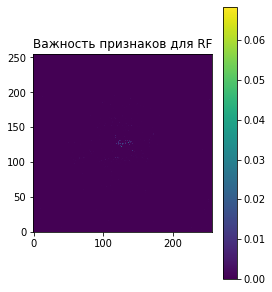

In [4]:
class PotentialTransformer:

    def fit(self, x, y):
        
        return self

    def fit_transform(self, x, y):

        return self.transform(x)

    def transform(self, x):

        return x.reshape((x.shape[0], -1))

pipe_RF = Pipeline(steps = [('transform', PotentialTransformer()), ('rf', RandomForestRegressor())])

pipe_RF.fit(X_train, y_train)

#Извлекаем важность признаков
rf_imp_features = pipe_RF.named_steps['rf'].feature_importances_

#Преобразование в матрицу для большей наглядности
rf_importance_matrix = np.abs(rf_imp_features.reshape(-1, 256))

#Строим рисунок важностей признаков
plt.figure(figsize=(4,5))
plt.title("Важность признаков для RF")
plt.imshow(rf_importance_matrix, origin = "lower", interpolation = "none")
plt.colorbar()

plt.show()

Вывод - все важные для случайного леса признаки находятся в центре изображения (если приглядется, то в центре точки светлее)

Теперь самый главный вопрос - какова точность предсказания нашего леса? Воспользуемся метрикой MAE, которая описывается следующей формулой:

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

In [6]:
print("MAE для случайного леса ==", mean_absolute_error(pipe_RF.predict(X_test), y_test))

MAE для случайного леса == 0.035807631842584266


Чтобы понять, хорошая это точность или не очень посмотрим на настоящие показания энергии и предсказанные в сравнении

In [10]:
y_predict = pipe_RF.predict(X_test)

print('    y_test                  y_predict')
for i in range(10):
    print(y_test[i], '  ', y_predict[i])

    y_test                  y_predict
0.14806020908451056    0.2208618843427753
0.22063470089790774    0.25670941170900746
0.20230534845634454    0.1626545825345355
0.095236119720077    0.11940356332111167
0.32113822654353286    0.3077937313571638
0.09345985280183314    0.1333535862091547
0.1729787119118874    0.17386947279882345
0.08324329336875888    0.12016944405201643
0.07659462709254726    0.07721090654846881
0.07146001506863821    0.06776673016853181


Да, это действительно хорошая точность, но можно ли сделать ее еще лучше? Да, можно. Например, надо попередвигать потенциал(преобразовать изображение). Идея следующая:

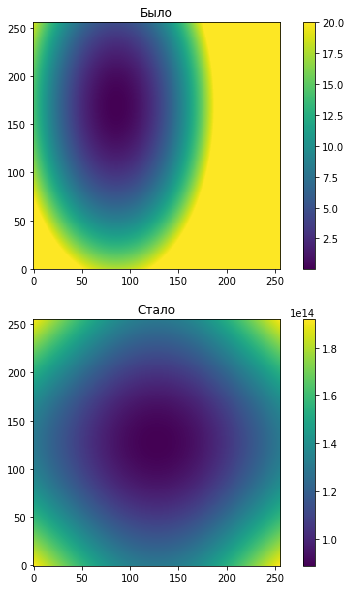

In [16]:
plt.figure(figsize=(8,10))

plt.subplot(2, 1, 1)
plt.title("Было")
plt.imshow(X_train[0], origin = "lower", interpolation = "none")
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title("Стало")
X_new = X_train[0] + X_train[0][:,::-1] + X_train[0][::-1,:] + X_train[0][::-1,::-1]
X_new = np.dot(X_new, X_new.T)
X_new = np.dot(X_new, X_new.T)

plt.imshow(X_new, origin = "lower", interpolation = "None")
plt.colorbar()

Благодаря действиям, запрограммированным выше, мы придали потенциалу некую симметрию относительно центра. Посмотрим, помогло ли это улучшить точность. Для этого преобразуем класс PotentialTransformer, который был описан в одном из блоков выше

In [17]:
class PotentialTransformer:

    def fit(self, x, y):

        return self.transform(x)

    def fit_transform(self, x, y):

        return self.transform(x)

    def transform(self, x):

        for i in range(len(x)):
            x[i][x[i]==20] = 35
            x[i] = x[i]
            x[i] = x[i] + x[i][:, ::-1] + x[i][::-1, :] + x[i][::-1, ::-1]
            x[i] = np.dot(x[i], x[i].T)
            x[i] = np.dot(x[i], x[i].T)

        return x.reshape((x.shape[0], -1))

Теперь обучим наш лес с новым трансформером:

In [18]:
pipe_RF = Pipeline(steps = [('transform', PotentialTransformer()), ('rf', RandomForestRegressor())])

pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 <__main__.PotentialTransformer object at 0x0000005807F6A3A0>),
                ('rf', RandomForestRegressor())])

Вычисляем метрику MAE:

In [19]:
mean_absolute_error(pipe_RF.predict(X_test), y_test)

0.01633430846788175

Можно видеть, что этот ход действительно улучшил качество предсказаний случайного леса

Итого, **случайный лес** - достаточно несложный алгоритм машинного обучения основанный на идее, что совокупность не сильно точных алгоритмов (каждое дерево по отдельности) может давать 